In [140]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

# Model Tuning and Training
Built-in Algorithms in Amazon SageMaker: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html


In [141]:
role = get_execution_role()

region = boto3.Session().region_name
bucket = 'ml-demo-device-failures'

sess = sagemaker.Session()
sm_client=sess.sagemaker_client

s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object('train/train.dat')
train_data_s3_path="s3://{}/{}".format(s3_input_train.bucket_name,s3_input_train.key)

s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object('validation/validation.dat')
validation_data_s3_path="s3://{}/{}".format(s3_input_validation.bucket_name,s3_input_validation.key)

s3_input_test = boto3.Session().resource('s3').Bucket(bucket).Object('test/test.csv')
test_data_s3_path = 'https://s3-{}.amazonaws.com/{}/{}'.format(region,s3_input_test.bucket_name,s3_input_test.key)

About XGboost Algorithm: https://arxiv.org/pdf/1603.02754.pdf
https://aws.amazon.com/sagemaker/pricing/instance-types/

During Model Training it is recommendable to use a Compute Optimized (ml.c5 type) or Accelerated Computing Instance (ml.p3) depeding on the training scenario.

In [142]:
container = get_image_uri(region, 'xgboost')

xgb_estimator = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.9xlarge',
                                    output_path='s3://{}/models/output'.format(bucket),
                                    sagemaker_session=sess,
                                    tags=[{"Key":"project","Value":"oxford_demo"}])

## Model Hyperparameter Tuning

Sagemaker Hyperparameter tuning uses an Amazon SageMaker implementation of Bayesian optimization.<br/>
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html<br/>


In [143]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter

xgb_estimator.set_hyperparameters(objective='binary:logistic',seed=123,base_score=0.5,n_thread=4,rate_drop=0.2)

param_dist_xgb = {
              'subsample': ContinuousParameter(0.3, 0.8),
              'max_depth': IntegerParameter(3, 9),
              'colsample_bytree': ContinuousParameter(0.45, 0.5),
              'min_child_weight': IntegerParameter(1, 3),
              'num_round':  IntegerParameter(150, 500),
              'lambda':   ContinuousParameter(0.05, 0.4)
              }

# Configure Hyperparameter Tuner
xgb_tuner = HyperparameterTuner(estimator=xgb_estimator,  # previously-configured Estimator object
                               objective_metric_name='validation:auc',
                               hyperparameter_ranges=param_dist_xgb,
                               max_jobs=100,
                               max_parallel_jobs=5,
                               base_tuning_job_name='device-failure-detection-xgboost-',
                               tags=[{"Key":"project","Value":"oxford_demo"}],
                               early_stopping_type="Auto"
                               )

## Model Training

In [144]:
xgb_tuner.fit(inputs={'train': train_data_s3_path, 'validation': validation_data_s3_path}) 

INFO:sagemaker:Creating hyperparameter tuning job with name: device-failure-detec-181215-0909


Checking Results of All Trained Models

In [180]:
xgb_tuner_analytics = xgb_tuner.analytics()
modelTuningOutputs=xgb_tuner_analytics.dataframe()
modelTuningOutputs.sort_values('FinalObjectiveValue',inplace=True, ascending=False)
modelTuningOutputs

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,colsample_bytree,lambda,max_depth,min_child_weight,num_round,subsample
10,0.770780,32.0,2018-12-15 09:41:35+00:00,device-failure-detec-181215-0909-053-756f94bc,Completed,2018-12-15 09:41:03+00:00,0.484454,0.284039,9.0,1.0,346.0,0.666593
25,0.706123,29.0,2018-12-15 09:33:20+00:00,device-failure-detec-181215-0909-039-581f0051,Completed,2018-12-15 09:32:51+00:00,0.484954,0.283339,9.0,1.0,350.0,0.669507
11,0.704371,38.0,2018-12-15 09:41:58+00:00,device-failure-detec-181215-0909-052-81182150,Completed,2018-12-15 09:41:20+00:00,0.484954,0.285573,9.0,1.0,343.0,0.671593
56,0.703559,33.0,2018-12-15 09:17:09+00:00,device-failure-detec-181215-0909-012-94c5347f,Completed,2018-12-15 09:16:36+00:00,0.498186,0.351619,8.0,3.0,381.0,0.583871
17,0.703351,32.0,2018-12-15 09:38:29+00:00,device-failure-detec-181215-0909-046-a90d2967,Completed,2018-12-15 09:37:57+00:00,0.484954,0.280539,9.0,1.0,350.0,0.671593
28,0.700484,34.0,2018-12-15 09:30:55+00:00,device-failure-detec-181215-0909-037-059d4491,Completed,2018-12-15 09:30:21+00:00,0.499457,0.060771,9.0,1.0,351.0,0.775281
41,0.686594,41.0,2018-12-15 09:25:01+00:00,device-failure-detec-181215-0909-025-a2b2e987,Completed,2018-12-15 09:24:20+00:00,0.492913,0.118698,6.0,1.0,468.0,0.698693
24,0.686084,29.0,2018-12-15 09:33:16+00:00,device-failure-detec-181215-0909-039-fcce9aa0,Completed,2018-12-15 09:32:47+00:00,0.499936,0.365287,7.0,1.0,250.0,0.716601
31,0.685702,30.0,2018-12-15 09:30:25+00:00,device-failure-detec-181215-0909-034-60989e7c,Completed,2018-12-15 09:29:55+00:00,0.498075,0.066093,9.0,1.0,345.0,0.693347
65,0.681576,29.0,2018-12-15 09:12:02+00:00,device-failure-detec-181215-0909-003-0d2baa86,Completed,2018-12-15 09:11:33+00:00,0.482661,0.350654,4.0,3.0,330.0,0.657589


# Model Deployment to An Endpoint for Inference

In [181]:
from time import strftime, gmtime
endpoint_name = 'device-failure-detection-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
device_failure_predictor = xgb_tuner.deploy(
    initial_instance_count=1, instance_type='ml.m4.xlarge',endpoint_name=endpoint_name
)

INFO:sagemaker:Creating model with name: xgboost-2018-12-15-09-44-37-342


2018-12-15 09:41:35 Starting - Preparing the instances for training
2018-12-15 09:41:35 Downloading - Downloading input data
2018-12-15 09:41:35 Training - Training image download completed. Training in progress.
2018-12-15 09:41:35 Uploading - Uploading generated training model
2018-12-15 09:41:35 Completed - Training job completedArguments: train
[2018-12-15:09:41:23:INFO] Running standalone xgboost training.
[2018-12-15:09:41:23:INFO] Setting up HPO optimized metric to be : auc
[2018-12-15:09:41:23:INFO] File size need to be processed in the node: 35.72mb. Available memory size in the node: 62036.63mb
[09:41:23] S3DistributionType set as FullyReplicated
[09:41:23] 87692x49 matrix with 2199997 entries loaded from /opt/ml/input/data/train
[09:41:23] S3DistributionType set as FullyReplicated
[09:41:23] 10469x49 matrix with 264441 entries loaded from /opt/ml/input/data/validation
[09:41:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_dept

INFO:sagemaker:Creating endpoint with name device-failure-detection-endpoint-2018-12-15-09-44-37


--------------------------------------------------------------------------!

In [182]:
sm_client.list_endpoints()

{'Endpoints': [{'EndpointName': 'device-failure-detection-endpoint-2018-12-15-09-44-37',
   'EndpointArn': 'arn:aws:sagemaker:eu-west-1:362097852896:endpoint/device-failure-detection-endpoint-2018-12-15-09-44-37',
   'CreationTime': datetime.datetime(2018, 12, 15, 9, 44, 38, 36000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2018, 12, 15, 9, 50, 49, 539000, tzinfo=tzlocal()),
   'EndpointStatus': 'InService'}],
 'ResponseMetadata': {'RequestId': '495d4ca9-03c2-458d-88bf-bb917e2a394b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '495d4ca9-03c2-458d-88bf-bb917e2a394b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '305',
   'date': 'Sat, 15 Dec 2018 09:50:51 GMT'},
  'RetryAttempts': 0}}

In [183]:
from sagemaker.predictor import csv_serializer

device_failure_predictor.content_type = 'text/csv'
device_failure_predictor.serializer = csv_serializer
device_failure_predictor.deserializer = None

Loading Test Data

In [184]:
test_data=pd.read_csv(test_data_s3_path)
test_data_X=test_data[np.setdiff1d(test_data.columns,['y', 'device', 'date'])].as_matrix()
test_data_Y=np.array(test_data['y'])

Lets predict a single test example!

In [185]:
device_failure_predictor.predict(test_data_X[10])

b'0.000134723886731'

# Model Evaluation

Predicting failure probability for Test Dataset

In [186]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, device_failure_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data_X)

Calculating Test Dataset Performance of the Best Model (Receiver Operating Curve Area Under Curve Score) 

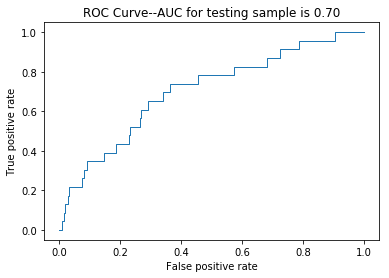

In [187]:
from sklearn.metrics import roc_curve, roc_auc_score, auc , confusion_matrix
#Compute ROC curve and area under the curve

fpr, tpr, thresholds = roc_curve(test_data_Y, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=1,
             label='ROC (AUC = %0.2f)' % (roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve--AUC for testing sample is %.2f' % 
          (roc_auc_score(test_data_Y,predictions)))
plt.show()

In [190]:
#calculate other information on resulting predictions
test_data['preds']=predictions

roc_df=pd.DataFrame({'fpr':fpr,'tpr':tpr,'thresholds':thresholds})
roc_df['error_rate_for_positives']=roc_df.fpr
roc_df['error_rate_for_negatives']=0
roc_df['tp'],roc_df['tn'],roc_df['fp'],roc_df['fn']=0,0,0,0
roc_df['tp_device'],roc_df['tn_device'],roc_df['fp_device'],roc_df['fp_device']=0,0,0,0
roc_df['device_error_rate_for_positives'],roc_df['device_error_rate_for_negatives']=0,0

temp=test_data.copy()

for n in range(roc_df.shape[0]):
    i=roc_df.loc[n,'thresholds']
    preds_01 = predictions >=i#/10.0
    preds_01=preds_01 *1
    cnf_matrix = confusion_matrix(test_data_Y, preds_01)#.ravel()
    tn,fp,fn,tp = cnf_matrix.ravel()
    roc_df.loc[n,'tp']=tp
    roc_df.loc[n,'fp']=fp
    roc_df.loc[n,'tn']=tn
    roc_df.loc[n,'fn']=fn
    roc_df.loc[n,'error_rate_for_positives'] = fp/(fp+tn)
    roc_df.loc[n,'error_rate_for_negatives'] = fn/(fn+tp)
    
    temp.loc[:,'pred']=preds_01
    accuracy=temp.groupby('device')[['y','pred']].sum()
    accuracy.loc[:,'predicted']=accuracy.pred>0
    a=pd.crosstab(accuracy.y,accuracy.predicted)
    if a.shape[1]==1:
        a.loc[:,'True']=0
    tn_device,fp_device,fn_device,tp_device=a.values.ravel()
    roc_df.loc[n,'tp_device']=tp_device
    roc_df.loc[n,'fp_device']=fp_device
    roc_df.loc[n,'tn_device']=tn_device
    roc_df.loc[n,'fn_device']=fn_device
    roc_df['device_error_rate_for_positives']=fp_device/(tn_device+fp_device)
    roc_df['device_error_rate_for_negatives']=fn_device/(fn_device+tp_device)

We received Confirmation on a rule which states Detecting a Single Failure has benefit to compensate the Cost of Checking 200 Non-Failed Devices

In [201]:
roc_df.trade_off=roc_df.fp-200*roc_df.tp
fp_cross=0
for i in range(len(roc_df.trade_off)-4,-1,-1):
    current=roc_df.trade_off[i]
    next_one = roc_df.trade_off[i+1]
    next_two = roc_df.trade_off[i+2]
    next_three = roc_df.trade_off[i+3]
    if (current<=0 and next_one >0 and next_two>0 and next_three >0): 
        fp_cross=roc_df.fp[i]
        print('fp_cross is ',fp_cross)
        break

fp_cross is  874


## Plotting a Confusion Matrix based on Cuttoff Threshold Calculated Above Via Cost-Benefit Analysis

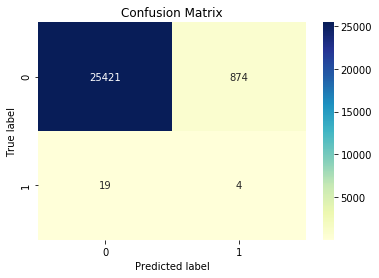

In [202]:
th_cross=roc_df.loc[roc_df.fp==fp_cross,'thresholds'].values[0]
preds_01 = predictions >=th_cross
preds_01=preds_01 *1
cnf_matrix = confusion_matrix(test_data_Y, preds_01)

ax=sns.heatmap(cnf_matrix,annot=True,fmt='d',cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Delete Endpoint (Just as a Cleanup)

In [179]:
sess.delete_endpoint(endpoint_name=device_failure_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: device-failure-detection-endpoint-2018-12-15-09-21-45


# Other Links

https://github.com/awslabs/amazon-sagemaker-examples <br/>
<a href="https://www.youtube.com/watch?v=FKY3A9RasGw">AWS re:Invent 2018: Build & Deploy ML Models Quickly & Easily with Amazon SageMaker (AIM404)</a>